In [1]:
import pandas as pd

In [2]:
insurance = pd.read_csv("insurance.csv", sep=",")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance[insurance["children"] == 1][insurance["age"] == 45]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,age,sex,bmi,children,smoker,region,charges
268,45,male,30.200,1,no,southwest,7441.05300
820,45,male,33.700,1,no,southwest,7445.91800
987,45,female,27.645,1,no,northwest,28340.18885
1037,45,female,30.495,1,yes,northwest,39725.51805


In [4]:
insurance.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [5]:
insurance.corr(method = "pearson")

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [6]:
import seaborn as sns
ax = sns.heatmap(insurance.corr(method = "pearson"), cmap = "vlag", annot=True)

In [7]:
categorical_columns = ['sex','children', 'smoker', 'region']
df_encode = pd.get_dummies(data = insurance, prefix = None, prefix_sep='_',
               columns = categorical_columns,
               drop_first =True)

df_encode.head()
df_encode.columns

Index(['age', 'bmi', 'charges', 'sex_male', 'children_1', 'children_2',
       'children_3', 'children_4', 'children_5', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [8]:
from scipy.stats import boxcox
y_bc,lam, ci= boxcox(df_encode['charges'],alpha=0.05)

In [9]:
y_bc

array([12.12897974,  8.80859638, 10.14752106, ...,  8.72968299,
        9.01913128, 12.9736611 ])

In [10]:
import numpy as np
df_encode['charges'] = np.log(df_encode['charges'])


In [11]:
df_encode['age_smoker_yes'] = df_encode['age']* df_encode['smoker_yes']
df_encode['age_sex_male'] = df_encode['age']* df_encode['sex_male']

df_encode.shape

(1338, 15)

In [12]:
from sklearn.model_selection import train_test_split
X = df_encode.drop('charges',axis=1) # Independet variable
y = df_encode['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

In [13]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

In [14]:
# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [15]:
# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df


,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,6.933947,6.933947
1,theta_1,age,0.037384,0.037384
2,theta_2,bmi,0.012043,0.012043
3,theta_3,sex_male,-0.267692,-0.267692
4,theta_4,children_1,0.152573,0.152573
5,theta_5,children_2,0.280255,0.280255
6,theta_6,children_3,0.254635,0.254635
7,theta_7,children_4,0.506222,0.506222
8,theta_8,children_5,0.498391,0.498391
9,theta_9,smoker_yes,2.784171,2.784171


In [16]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  0.1568318048680425
R square obtain for normal equation method is : 0.8154227058930674


In [17]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  0.15683180486793147
R square obtain for scikit learn library is : 0.8154227058931979


In [18]:
# Backward elimination
import statsmodels.api as sm
X_train_0 = sm.add_constant(X_train)
X_test_0 = sm.add_constant(X_test)
ols = sm.OLS(endog=y_train, exog= X_train_0).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     271.0
Date:                Mon, 10 Sep 2018   Prob (F-statistic):          9.98e-315
Time:                        15:27:40   Log-Likelihood:                -482.19
No. Observations:                 936   AIC:                             994.4
Df Residuals:                     921   BIC:                             1067.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.9339      0.089  

In [20]:
# Backward elimination
# Step 2
import statsmodels.api as sm
X_train_1 = X_train.drop('region_northwest',axis=1)
X_test_1 = X_test.drop('region_northwest',axis=1)
X_train_2 = sm.add_constant(X_train_1)
X_test_2 = sm.add_constant(X_test_1)
ols = sm.OLS(endog=y_train, exog= X_train_2).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     291.2
Date:                Mon, 10 Sep 2018   Prob (F-statistic):          1.87e-315
Time:                        15:27:44   Log-Likelihood:                -483.39
No. Observations:                 936   AIC:                             994.8
Df Residuals:                     922   BIC:                             1063.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.9028      0.087  

In [21]:
# Prediction for ols model
y_pred_ols = ols.predict(X_test_2)

In [25]:
import matplotlib.pyplot as plt

In [22]:
import seaborn as sns; sns.set()

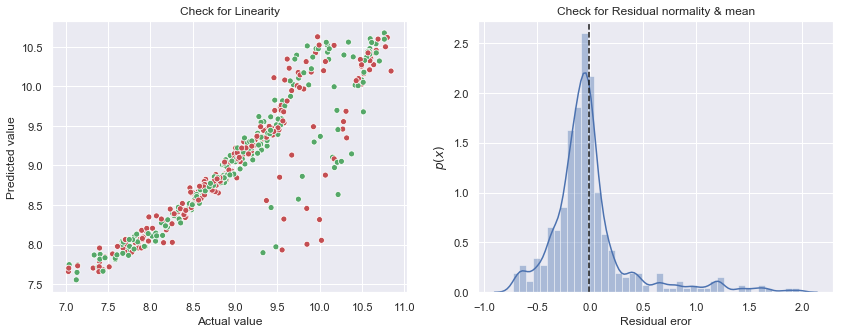

In [27]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_ols,ax=ax,color=['r','g'])
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_ols),ax=ax,color='b')
plt.axvline((y_test - y_pred_ols).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

In [44]:
# tips = sns.load_dataset("tips")
y_test

918      9.475924
755      8.523428
207      9.951520
520     10.152555
695      8.071295
567      8.889684
956     10.645413
353      9.425845
25       9.546894
1240    10.763628
363      7.862412
890     10.286400
1276     7.916424
287      9.564947
931      8.738463
965      8.465130
408      8.802752
1038     7.719057
1090    10.637683
84      10.592539
328     10.777456
1180     8.942562
1173     8.773051
260      9.378999
1022    10.650439
670      8.484170
320      8.495919
263     10.497350
469      7.696711
748      9.054494
          ...    
1071     9.544986
147      9.198026
238      9.761502
575      9.411066
586      8.258736
739     10.705163
953     10.571280
528      9.029167
229      9.129700
19      10.514271
1227     8.876546
806     10.256843
130      9.458406
28       7.928475
846      9.197529
841      9.419299
1051     9.574605
985      8.939139
1258    10.311070
976      8.962412
1190     8.580619
277      7.673441
1013     9.078550
783     10.107255
52      10

In [42]:
tips_1 = pd.concat([y_test, y_pred_ols], axis=1).reset_index()

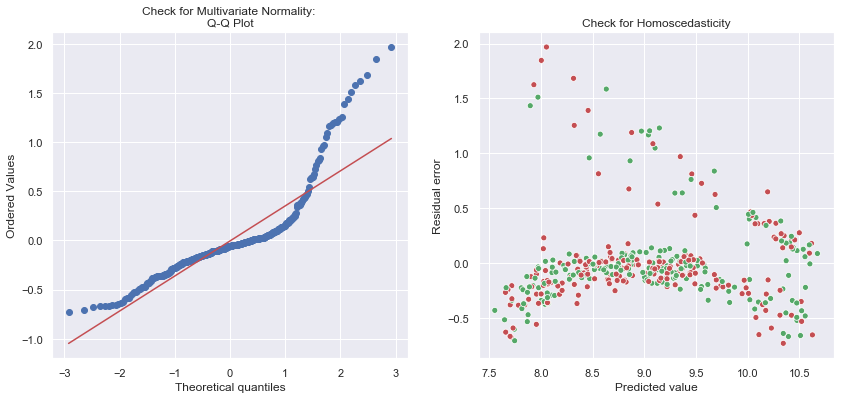

In [28]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_ols),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_ols), x= y_pred_ols, ax = ax[1],color=['r','g']) 
ax[1].set_title('Check for Homoscedasticity')
plt.xlabel('Predicted value')
plt.ylabel('Residual error');

In [29]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- ols.rsquared)
VIF

5.105774693629873